In [1]:
import pandas as pd
from Bio.PDB import *
import numpy as np
import warnings
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
import random
parser = PDBParser(PERMISSIVE=1)




In [2]:
def get_ca_atoms(pdb_file, start_resnum=102, num_residues=50):
    """
    Parses a PDB file and returns the coordinates of alpha carbons (CA) for a
    specified range of residues.
    
    Args:
        pdb_file (str): The name of the PDB file to parse.
        start_resnum (int): The residue number to start extracting alpha carbons from.
        num_residues (int): The number of residues to extract alpha carbons from.
        
    Returns:
        A tuple containing two lists: the coordinates of alpha carbons (CA) and the
        residue names for each alpha carbon.
    """
    structure = parser.get_structure('6lu7', '6lu7.pdb')
    ca_atoms = []
    residue_count = 0
    
    for model in structure:
        for chain in model:
            for residue in chain:
                resnum = residue.get_id()[1]
                if resnum >= start_resnum and resnum < start_resnum + num_residues:
                    for atom in residue:
                        if atom.get_name() == 'CA':
                            ca_atoms.append(atom.get_coord())
                            residue_count += 1
                            break
                if residue_count == num_residues:
                    break
            if residue_count == num_residues:
                break
    
    return np.array(ca_atoms)

In [3]:
ca_atoms=get_ca_atoms('6lu7.pdb',start_resnum=102, num_residues=50)
ca_atoms

array([[-33.343,  26.18 ,  60.877],
       [-31.916,  24.031,  63.672],
       [-33.501,  20.58 ,  63.455],
       [-32.716,  17.283,  65.158],
       [-33.12 ,  14.41 ,  62.707],
       [-34.263,  10.844,  63.402],
       [-32.407,   7.553,  62.945],
       [-32.757,   6.413,  59.353],
       [-32.911,   9.958,  57.984],
       [-30.174,  11.341,  55.749],
       [-28.249,  14.59 ,  55.396],
       [-25.286,  16.046,  53.527],
       [-21.937,  16.611,  55.249],
       [-19.599,  19.477,  54.354],
       [-16.209,  18.305,  55.616],
       [-14.143,  21.38 ,  56.496],
       [-10.576,  21.862,  57.717],
       [ -9.35 ,  25.159,  59.202],
       [-12.598,  26.855,  58.194],
       [-12.134,  25.844,  54.539],
       [-14.554,  23.31 ,  52.997],
       [-12.852,  20.428,  51.199],
       [-15.622,  17.959,  50.331],
       [-19.322,  17.178,  50.492],
       [-21.078,  13.816,  50.757],
       [-24.341,  12.272,  51.923],
       [-24.686,  10.612,  55.328],
       [-27.407,   8.712,  5

In [4]:
def CM_mtrx(atoms):
    n = atoms.shape[0]
    cm_matrix = np.zeros(shape=(n+1, n+1))
    cm_matrix[0,:]=1
    cm_matrix[:,0]=1
    cm_matrix[0,0]=0
    for i in range(n):
        for j in range(n):
            if i <= j:
                val_1 = atoms[i]
                val_2 = atoms[j] 
                dist = np.linalg.norm(val_1-val_2)
                cm_matrix[i+1][j+1] = (dist**2)/2
                cm_matrix[j+1][i+1] = (dist**2)/2
            elif i == j:
                cm_matrix[i,j] = 0

    return cm_matrix



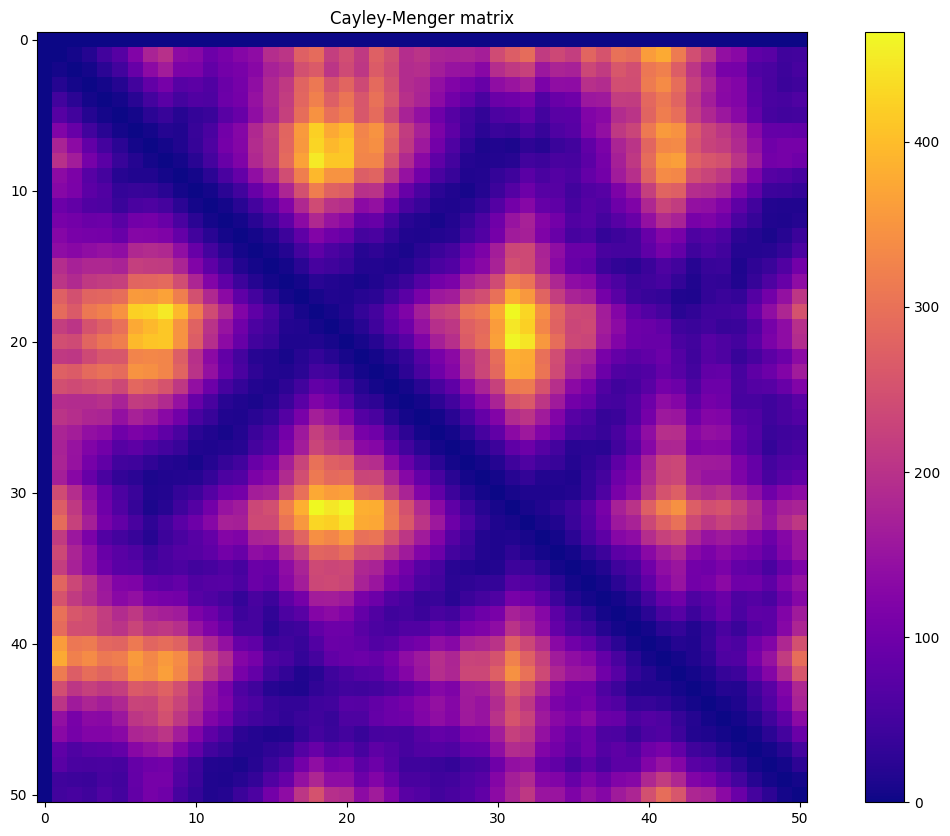

In [5]:
cm_matrix = CM_mtrx(ca_atoms)

fig, ax = plt.subplots(figsize=(15,10)) 
im = ax.imshow(cm_matrix, cmap='plasma')
plt.colorbar(im)
plt.title('Cayley-Menger matrix')
plt.show()


**Question_1**

In [6]:
rank=np.linalg.matrix_rank(cm_matrix, tol = 0.01)
print(f'The rank of the Cayley-Menger matrix is {rank}')

The rank of the Cayley-Menger matrix is 5


**Question_2**

In [7]:
def perturb(mtrx,perc):
    pert_mtrx=np.zeros(shape=mtrx.shape)
    pert_mtrx[0,:]=1
    pert_mtrx[:,0]=1
    pert_mtrx[0,0]=0
    for i in range(1,mtrx.shape[0]):
        for j in range(1,mtrx.shape[1]):
            if i==0 or j==0: 
                continue
            elif i<j:  # since the diagonal is zero
                num = np.random.uniform(1-perc/100, 1+perc/100)
                pert_val = abs(num*mtrx[i,j])
                pert_mtrx[i,j] = pert_val
                pert_mtrx[j,i] = pert_val
    return pert_mtrx            
         

In [8]:
pert_mtrx = perturb(cm_matrix,5)
rank=np.linalg.matrix_rank(pert_mtrx, tol = 0.01)
print(f'The rank of the perturbated matrix is {rank}')

The rank of the perturbated matrix is 50


In [9]:
def Gram_mtrx(mtrx):
    gram_mtrx=np.zeros(shape=(mtrx.shape[0]-1,mtrx.shape[1]-1))
    for i in range(gram_mtrx.shape[0]):
        for j in range(gram_mtrx.shape[1]):
            gram_mtrx[i,j]=mtrx[i+1,1]+mtrx[j+1,1]-mtrx[i+1,j+1]
    return gram_mtrx        

In [10]:
gram_mtrx=Gram_mtrx(pert_mtrx)
gram_mtrx.shape

(50, 50)

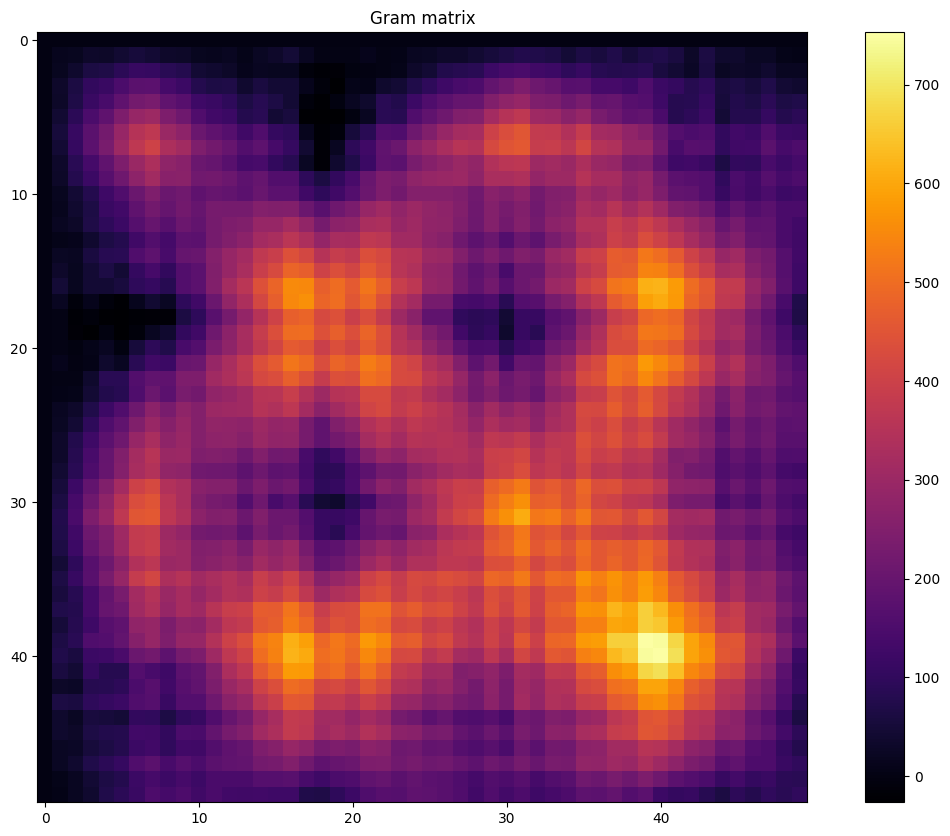

In [11]:
fig, ax = plt.subplots(figsize=(15,10)) 
im = ax.imshow(gram_mtrx, cmap='inferno')
plt.colorbar(im)
plt.title('Gram matrix')
plt.show()


In [14]:
def S_arr(mtrx):
    _ , s, vT = np.linalg.svd(mtrx, full_matrices=True)
    sorted_values = np.sort(s.flatten(),kind='mergesort')
    rev_sort=sorted_values[::-1]
    arr = np.zeros((3,3))
    for i in range(mtrx.shape[0]):
        if i < 3:
            arr[i, i] = rev_sort[i]
        else:
            break
    return arr, vT 

In [15]:
Sigma_mtrx, vT = S_arr(gram_mtrx)

In [17]:
coordinates = (np.sqrt(Sigma_mtrx) @ vT[:3,:]).T
coordinates.shape


(50, 3)

In [18]:
coordinates

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.15975278e+00, -1.51319168e+00,  3.04379043e+00],
       [-3.17488574e+00, -4.90962155e+00,  2.76913218e+00],
       [-5.75431518e+00, -7.22247722e+00,  4.22637658e+00],
       [-7.45731810e+00, -9.44427961e+00,  1.30334542e+00],
       [-8.84341210e+00, -1.27204283e+01,  1.82167964e+00],
       [-1.23450119e+01, -1.42546938e+01,  1.18445410e+00],
       [-1.36520349e+01, -1.46085699e+01, -2.24336316e+00],
       [-1.12778400e+01, -1.18482084e+01, -3.51678209e+00],
       [-1.28903851e+01, -8.59647968e+00, -5.28444787e+00],
       [-1.18493691e+01, -4.85247733e+00, -4.68599278e+00],
       [-1.38185559e+01, -1.61763673e+00, -5.82941280e+00],
       [-1.52008771e+01,  7.98552410e-01, -3.36330950e+00],
       [-1.54447960e+01,  4.43504491e+00, -3.68736068e+00],
       [-1.84593202e+01,  5.54559486e+00, -1.67394997e+00],
       [-1.85582382e+01,  8.95176862e+00, -4.94154661e-01],
       [-2.05717034e+01,  1.12821769e+01

In [19]:
def centered(array):
    mean = np.mean(array, axis=0)
    arr_centered = array - mean
    return arr_centered

In [20]:
cent_ca_atoms = centered(ca_atoms)
cen_coordinates = centered(coordinates)

In [21]:
def crmsd(mtrx_1,mtrx_2):
    temp_mtrx = mtrx_1.T@mtrx_2
    u, s, vT = np.linalg.svd(temp_mtrx, full_matrices=True)
    Q_mtrx = u@vT
    if np.linalg.det(Q_mtrx)<0:
        u[:,-1]*= -1
        Q_mtrx = u@vT
    A_mtrx = mtrx_1@Q_mtrx.T-mtrx_2
    value = np.sqrt(np.sum(pow((np.linalg.norm(A_mtrx)),2)/mtrx_1.shape[0]))
    return value

In [22]:
cRMSD = crmsd(cent_ca_atoms,cen_coordinates)
cRMSD

8.22990846115472